In [2]:
import pandas as pd
import numpy as np
from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv('./all_stocks_5yr.csv')
data.head(3)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL


In [3]:
missing_values = []
missing_values = data[data.isnull().any(axis=1) == True]
missing_values

,date,open,high,low,close,volume,Name
82949,2017-07-26,NaN,NaN,NaN,69.0842,3,BHF
165734,2015-07-17,NaN,88.76,88.24,88.7200,2056819,DHR
165857,2016-01-12,NaN,NaN,NaN,88.5500,0,DHR
205076,2015-07-17,NaN,48.49,47.85,47.9200,1246786,ES
239832,2016-07-01,NaN,NaN,NaN,49.5400,0,FTV
434379,2015-07-17,NaN,47.31,46.83,46.9900,1229513,O
434502,2016-01-12,NaN,NaN,NaN,52.4300,0,O
478594,2015-06-09,NaN,NaN,NaN,526.0900,12135,REGN
558213,2016-04-07,NaN,NaN,NaN,41.5600,0,UA
581906,2015-05-12,NaN,NaN,NaN,124.0800,569747,VRTX


In [4]:
data.dropna(inplace=True)

In [5]:
missing_values = []
missing_values = data[data.isnull().any(axis=1) == True]
missing_values

,date,open,high,low,close,volume,Name


In [6]:
data_MSFT = data[data.Name == 'MSFT']
data_MSFT.head(3)

,date,open,high,low,close,volume,Name
390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT


In [7]:
asd = data_MSFT[['date', 'close']]
asd.head(3)

,date,close
390198,2013-02-08,27.55
390199,2013-02-11,27.86
390200,2013-02-12,27.88


In [8]:
#MSFT[MSFT.index == 390423]

In [9]:
#asd = MSFT[MSFT.index <= 390423]
#asd.head(3)
#asd.dtypes

In [10]:
asd['new_date'] = pd.to_datetime(asd['date'])
asd.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,date,close,new_date
390198,2013-02-08,27.55,2013-02-08
390199,2013-02-11,27.86,2013-02-11
390200,2013-02-12,27.88,2013-02-12


In [11]:
asd = asd.drop(['date'], axis=1)

In [12]:
asd.head(3)

,close,new_date
390198,27.55,2013-02-08
390199,27.86,2013-02-11
390200,27.88,2013-02-12


Test MSE: 5.138


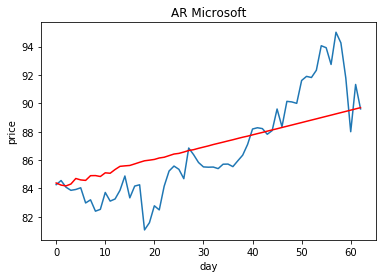

In [13]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
X = asd.close.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:]

model = AR(train)
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train) + len(test)-1)
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.title("AR Microsoft")
plt.xlabel('day')
plt.ylabel('price')
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()


Test MSE: 351.154


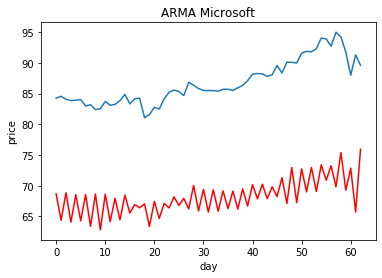

In [14]:
from statsmodels.tsa.arima_model import ARMA

X = asd.close.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = []


for t in range(len(test)):
    model =ARMA(history, order=(0, 1))
    model_fit = model.fit(disp=False)
    output = model_fit.predict(start=len(history), end=len(history)+len(test)-1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.title("ARMA Microsoft")
plt.xlabel('day')
plt.ylabel('price')
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Test MSE: 36.764


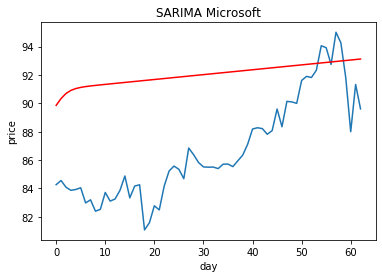

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMA example

X = asd.close.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]

model =SARIMAX(history, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)
predictions = model_fit.predict(start=len(history), end=len(history)+len(test)-1, dynamic=False)
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.title("SARIMA Microsoft")
plt.xlabel('day')
plt.ylabel('price')
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Test MSE: 17.471


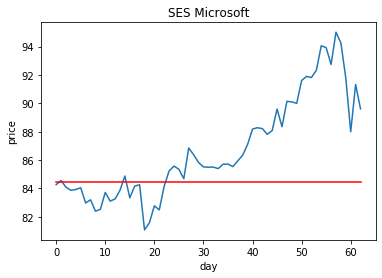

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

X = asd.close.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

model =SimpleExpSmoothing(history)
model_fit = model.fit()
predictions = model_fit.predict(start=len(history), end=len(history)+len(test)-1)
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.title("SES Microsoft")
plt.xlabel('day')
plt.ylabel('price')
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Test MSE: 17.471


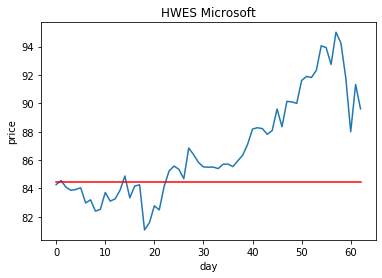

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

X = asd.close.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []



model =ExponentialSmoothing(history)
model_fit = model.fit()
predictions = model_fit.predict(start=len(history), end=len(history)+len(test)-1)

    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.title("HWES Microsoft")
plt.xlabel('day')
plt.ylabel('price')
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Test MSE: 8.400


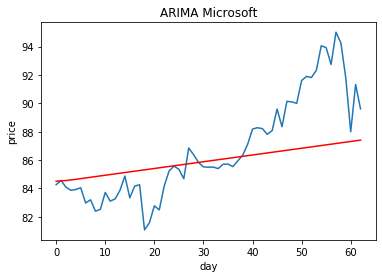

In [18]:
from statsmodels.tsa.arima_model import ARIMA

X = asd.close.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:] 

model = ARIMA(train, order=(5,1,0))
model_fit = model.fit(disp=0)
predictions = model_fit.forecast(steps=len(test))[0]


error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.title("ARIMA Microsoft")
plt.xlabel('day')
plt.ylabel('price')
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()